In [ ]:
from bmcs_shell.api import WBTessellation4PEx
import k3d
import numpy as np

**About the notebook:**

This notebooks include the target original geometry of the planned waterbomb demonstartor element and an evaluation of the 3d-scanned geometries of some of the produced elements in 01.2024.

# Evaluating scanned 3D demonstrator elements

## Geometry of the target element

In [ ]:
wb_shell = WBTessellation4PEx(
                         a=1000/4,
                         b = 1615/4, 
                         c = 645/4, 
                         e_x = 286/4,
                         gamma=0.683, # a value of gamma = 0.75 was estimated from normals, but a CAD comparison showed that 0.75 doesn't lead to closer geometry to the scanned 
                         n_phi_plus=2, # planned 5 
                         n_x_plus=2,  # planned 3
                         wireframe_width=5,
                        ##---- Trimming function works only in WBTessellation4P ----##
                         trim_half_cells_along_y=True,
                         trim_half_cells_along_x=True,
#                          align_outer_nodes_along_x=True,
)
wb_shell.interact()

## Evaluating the 3D-scanned WB5 element exported from Rhino as OBJ mesh

The following cells include a comparison between a obj file exported from Rhino for the lower surface of the scanned shell WB5. The model was built in rhino using "Fit plane through points" function in Rhino evaluating planes at about 10 points at each surface and the mesh is created manually so that it corresponds to the mesh we use in Python. 

Notice that the boundaries of the elements includes manual trimming, therefore the location of the points in the OBJ file is not perfect and the normals of the surfaces are the most reliable data.

In [1]:
def obj_file_mesh_to_numpy(file_path):
    with open(file_path) as file:
        lines = [line.rstrip() for line in file]
    X_Ia = np.array([np.array(line[2:].split(' '), dtype=np.float_) for line in lines if line.startswith('v')])
    I_Fi = np.array([np.array(line[2:].split(' '), dtype=np.int_) for line in lines if line.startswith('f')]) -1
    return X_Ia, I_Fi

In [ ]:
scan_X_Ia, scan_I_Fi = obj_file_mesh_to_numpy('wb5_cad_from_3d_scan.obj')
scan_X_Ia, scan_I_Fi.shape

In [ ]:
orig_I_Fi = np.copy(wb_shell.I_Fi_trimmed)
orig_X_Ia = np.copy(wb_shell.X_Ia_trimmed)
orig_X_Ia, orig_I_Fi

In [ ]:
import k3d
plot = k3d.plot()
red=0xff0000

mesh1 = k3d.mesh(scan_X_Ia, scan_I_Fi, side='double', color=red)
plot += mesh1

mesh2 = k3d.mesh(orig_X_Ia, orig_I_Fi, side='double')
plot += mesh2

plot.display()

## Evaluating 3D-scanned elements exported as facets points

The facets are numbered from the center of the cell in anti-clockwise sense, first the lower surface facets from 1 to 14, then the upper plastic parts from 15 to 22, see

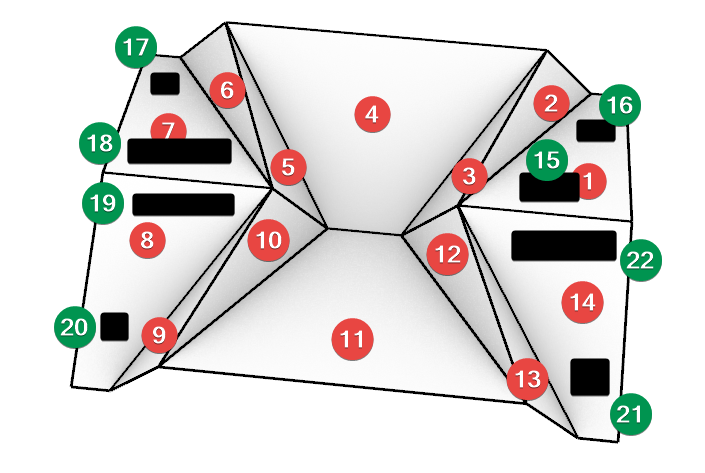

In [35]:
# This function returns a list of lists, each containing the points of the corresponding facet from 1 to 14

def obj_file_points_to_numpy(file_path):
    facets_points = []
    with open(file_path) as file:
        facet_num = None
        for line in file:
            line = line.strip()
            if line.startswith('o'):
                if facet_num is not None:
#                     facets_points.append([facet_num, facet_points])
                    facets_points.append({facet_num: facet_points})
                facet_points = []
                facet_num = int(line[2:])
            elif line.startswith('v'):
                facet_points.append(np.array(line[2:].split(' '), dtype=np.float_))
        # append also the last set of points
        facets_points.append({facet_num: facet_points})   
    
    # Sort facets and convert them to a list of lists
    facets_points = sorted(facets_points, key=lambda d: list(d.keys())[0])
    facets_points = [np.array(next(iter(dic.values()))) for dic in facets_points]
    
    return facets_points

In [50]:
wb5_facets_points = obj_file_points_to_numpy('wb5_facets_points.obj')
wb7_facets_points = obj_file_points_to_numpy('wb7_facets_points.obj')
wb8_facets_points = obj_file_points_to_numpy('wb8_facets_points.obj')
wb5_facets_points, wb7_facets_points, wb8_facets_points

([array([[ 489.26   , -328.7    ,  -33.76   ],
         [ 509.5    , -227.41   ,    0.92172],
         [ 391.46   , -156.89   ,   23.937  ],
         [ 501.85   ,  -61.213  ,   57.069  ],
         [ 329.65   ,  -41.598  ,   63.174  ]]),
  array([[ 432.52  , -340.81  ,  -11.479 ],
         [ 401.53  , -286.18  ,    1.9294],
         [ 351.82  , -221.09  ,   31.467 ],
         [ 312.48  , -183.73  ,   59.776 ],
         [ 317.31  , -161.99  ,   46.816 ],
         [ 275.25  ,  -75.582 ,   60.231 ]]),
  array([[ 290.64  , -238.76  ,   50.386 ],
         [ 253.63  , -185.2   ,   32.442 ],
         [ 244.9   , -104.06  ,   57.232 ],
         [ 214.82  ,  -26.185 ,   56.925 ],
         [ 158.18  ,  -22.072 ,   -3.2036]]),
  array([[ 277.32  , -337.86  ,   62.484 ],
         [ 168.95  , -221.44  ,   29.983 ],
         [ 103.43  ,  -72.557 ,  -13.685 ],
         [-148.33  , -336.33  ,   63.982 ],
         [ -83.137 , -230.65  ,   33.719 ],
         [  -3.7062,  -60.978 ,  -16.944 ]]),
  array([

In [37]:
def get_best_plane_coeffs(points):
    from scipy.optimize import least_squares

    def residuals(coeffs, xy, z):
        plane_z = coeffs[0] * xy[0] + coeffs[1] * xy[1] + coeffs[2]
        return plane_z - z

    x, y, z = points[:, 0], points[:, 1], points[:, 2]

    # Initial guess for the plane coefficients
    initial_coeffs = [1, 1, 1]

    # Use least squares fitting to find the best-fitting plane
    result = least_squares(residuals, initial_coeffs, args=(np.array([x, y]), z))

    # Return the optimized plane coefficients
    return result.x

In [38]:
# Get coeffs of the first plane (upper right)
get_best_plane_coeffs(wb7_facets_points[0])

array([ 6.23795005e-03, -3.38099828e-01,  7.42059834e+01])

# Vector analysis of the mismatch

Quantify the difference between ideal and scanned shell

In [ ]:
def plot_wb(X_Ia, I_Fi, color=''):
    global plot
    # Assuming scan_X_Ia is a 2D array specifying vertices of the mesh
    mesh1 = k3d.mesh(X_Ia, I_Fi, side='double', color=color)
    plot += mesh1
    # Assuming node_numbers and node_positions are defined
    # Node numbers are represented as a list of strings
    # Node positions is an Nx3 array where N is the number of nodes and each row is the 3D position of a node
    node_numbers = [str(i) for i in range(X_Ia.shape[0])]
    node_positions = X_Ia.reshape((-1,3))

    for i in range(len(node_numbers)):
        text = k3d.text(text=node_numbers[i], position=node_positions[i], color=0x0, size=1)
        plot += text

In [ ]:
orig_X_Ia, orig_I_Fi, scan_X_Ia, scan_I_Fi
orig_X_Ia - scan_X_Ia;

## Compare the length of scanned and ideal crease lines

Plot the shells with node numbers to construct the line vectors.

In [ ]:
plot = k3d.plot()
red=0xff0000
blue=0x0000ff

#plot_wb(scan_X_Ia, scan_I_Fi, color=red)
plot_wb(orig_X_Ia, orig_I_Fi, color=blue)
plot.display()

## Length of lines

Check the difference between $OV^+$ and $OV^-$ vectors which are the primary indicators of non-symmetry.

In [ ]:
def get_length_Li(X_Ia, I_Li):
    vec_Li = X_Ia[I_Li[:, 1]] - X_Ia[I_Li[:, 0]]
    return np.linalg.norm(vec_Li, axis=1)

What is the difference between the length of the symmetric vectors $OV^{+} - OV^{-}$.

In [ ]:
scan_OV_I_Li = np.array([[1,6],[7,9]])
scan_OV_length_L = get_length_Li(scan_X_Ia, scan_OV_I_Li)
orig_OV_I_Li = np.array([[1,7],[0,6]])
orig_OV_length_L = get_length_Li(orig_X_Ia, orig_OV_I_Li)
d_OV_L = orig_OV_length_L - scan_OV_length_L
d_OV_L, np.sum(np.abs(d_OV_L))


# Old evaluations using WB5 normals exported from Rhino

## Extracting surfaces normals

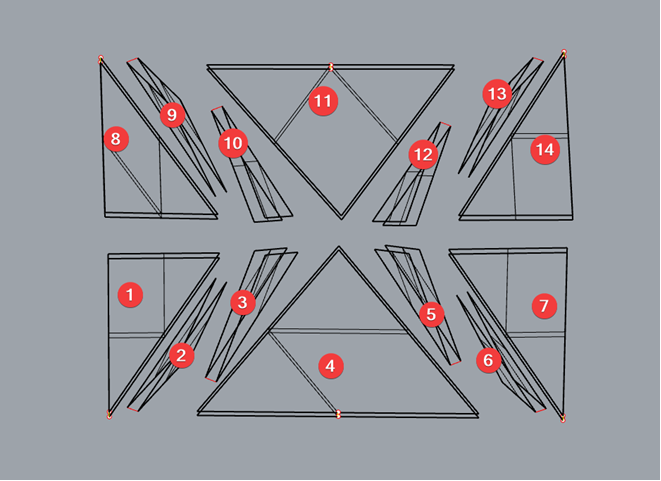

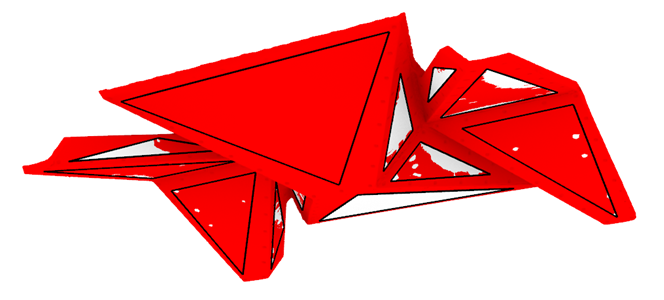

In [ ]:
extracted_normal_lines_from_rhino= np.array([[(19.2598,-1110.06,3.66752),
      (19.4497,-1119.79,32.0426)],

      [(78.2531,-1108.3,13.7863),
      (56.5015,-1100.46,32.9034)],

      [(237.98,-1048.35,121.023),
      (216.055,-1039.68,102.473)],

      [(486.547,-1118.97,111.346),
      (486.657,-1110.72,140.189)],

      [(737.623,-1005.79,97.535),
      (716.34,-1014.06,116.993)],

      [(890.645,-1110.04,16.0945),
      (911.87,-1102.94,36.0722)],

      [(946.248,-1117.42,-0.440456),
      (946.166,-1127.18,27.9273)],

      [(1.50688,-395.88,9.32416),
      (1.67641,-386.418,37.7925)],

      [(77.6118,-387.01,14.3671),
      (55.1252,-395.583,32.2795)],

      [(228.155,-494.062,105.649),
      (250.139,-485.528,124.193)],

      [(471.408,-401.123,109.321),
      (471.83,-409.649,138.08)],

      [(717.082,-525.913,92.2506),
      (695.804,-517.909,111.825)],

      [(885.475,-386.334,20.9253),
      (906.659,-393.371,40.9685)],

      [(948.319,-384.048,3.5526),
      (948.095,-374.455,31.9765)]])

In [ ]:
rhino_vectors = extracted_normal_lines_from_rhino[:, 1] - extracted_normal_lines_from_rhino[:, 0]
normals = np.zeros_like(rhino_vectors)
for i, v in enumerate(rhino_vectors):
    normals[i] = v / np.linalg.norm(v)
normals

In [ ]:
signs = np.ones_like(normals)
# signs[1] *= -1
signs[2] *= -1
# signs[4] *= -1
# signs[5] *= -1
aligned_normals = normals * signs
aligned_normals

In [ ]:
parallel_facets = np.array([[8, 4], [14, 4], [1, 11], [11, 7], [9, 5], [10, 6], [12, 2], [13, 3]]) - 1
parallel_facets

In [ ]:
parallel_normals = (aligned_normals)[parallel_facets]
parallel_normals

In [ ]:
u_vectors, v_vectors = np.einsum('ijk->jik', parallel_normals)

In [ ]:
u_vectors - v_vectors

In [ ]:
cos_alpha = np.einsum('pi,pi->p', u_vectors, v_vectors)

In [ ]:
alpha = np.arccos(cos_alpha)
alpha / (2*np.pi) * 360

In [ ]:
np.tan(alpha)

## Determination of the folding angle $\gamma$ from 3d scan

In [ ]:
OV_r = np.array([[414.769,379.713,5.69859], [307.495, 380.431, 126.014]])
# OV_r = np.array([[411.559,379.113,6.24218], [307.495,380.431,126.014]])

V_OV_r = OV_r[1] - OV_r[0]
v_OV_r = V_OV_r/np.linalg.norm(V_OV_r)
OV_r, V_OV_r, v_OV_r

In [ ]:
OV_l = np.array([[552.832,379.904,6.19581], [666.678,385.051,123.01]])
V_OV_l = OV_l[1] - OV_l[0]
v_OV_l = V_OV_l/np.linalg.norm(V_OV_l)
OV_l, V_OV_l, v_OV_l

In [ ]:
OO = np.array([[414.769,379.713,5.69859], [552.832,379.904,6.19581]])
V_OO = OO[1] - OO[0]
v_OO = V_OO/np.linalg.norm(V_OO)
OO, V_OO, v_OO

In [ ]:
gamma_r = np.pi/2 - np.arccos(np.einsum('i,i->', v_OV_r, -v_OO))
gamma_l = np.pi/2 -np.arccos(np.einsum('i,i->', v_OV_l, v_OO))
gamma = (gamma_l + gamma_r)/2
gamma, gamma_l, gamma_r, np.rad2deg(gamma_l), np.rad2deg(gamma_r)